# Find Signature Gene Profiles
```
Andrew E. Davidson
aedavids@ucsc.edu
```

We can use the profiles to deconvole bulk tissue and plasma sample

Data set: GTEx+TCGA 1vsAll results

ref:
- extraCellularRNA/terra/deseq/doc/plots
- extraCellularRNA/terra/deseq/doc/plots/jupyterNotebooks/GTExValidateExploration.ipynb
- https://support.terra.bio/hc/en-us/articles/360042259232-Managing-data-and-automating-workflows-with-the-FISS-API
- [An introduction to using the Fiss API in Python in BioData Catalyst](https://terra.biodatacatalyst.nhlbi.nih.gov/#workspaces/biodata-catalyst/BioData%20Catalyst%20Collection/notebooks/launch/Intro%20to%20FISS%20API%20in%20Python.ipynb)
- [upsetPlot](https://upsetplot.readthedocs.io/en/stable/api.html#upsetplot.plot)
- https://www.adamsmith.haus/python/answers/how-to-read-a-dictionary-from-a-file-in--python
- terra/jupyterNotebooks/exploreUpsetPlotInteresections.ipynb

## TODO
- implement find best and find down

## initialize

In [1]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%Y-%b-%d %H:%M:%S")
print("Run on ", current_time)

Run on  2022-Aug-11 17:18:41


In [2]:
from   firecloud import fiss
import firecloud.api as fapi
import io
from   matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from   pathlib import Path
import upsetplot as upsp


# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display, Image

In [3]:
tmp = "./tmp"
!mkdir -p $tmp

In [4]:
# set env var used by fiss
# Get the Google billing project name and workspace name
billing_project = os.environ['WORKSPACE_NAMESPACE']
workspace = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET'] + "/"

print("Billing project: " + billing_project)
print("Workspace: " + workspace)
print("Workspace storage bucket: " + bucket)

Billing project: test-aedavids-proj
Workspace: uber
Workspace storage bucket: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/


In [5]:
# Install a pip package in the current Jupyter kernel
# https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install --quiet upsetplot

# install upset plot
# see extraCellularRNA/terra/deseq/bin/createUpsetPlotZip.sh
url = bucket + "python/upsetPlot.zip"
! gsutil cp $url .
! unzip -o upsetPlot.zip > /dev/null
ORIG_PYTHONPATH = os.environ['PYTHONPATH']

Copying gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/python/upsetPlot.zip...
/ [1 files][ 13.0 MiB/ 13.0 MiB]                                                
Operation completed over 1 objects/13.0 MiB.                                     


In [6]:
# setting the python path allows us to run python scripts from using
# the CLI. 
PYTHONPATH = ORIG_PYTHONPATH + ":./python"
os.environ["PYTHONPATH"] = PYTHONPATH
PYTHONPATH = os.environ["PYTHONPATH"]
print("PYTHONPATH: {}".format(PYTHONPATH))

# test install. We should get a help message
! python python/plots/geneSignatureUpsetPlot.py

# to be able to import our local python files we need to set the sys.path
# https://stackoverflow.com/a/50155834
sys.path.append(os.getcwd() + '/python')
print("\nsys.path:\n{}\n".format(sys.path))

from   plots.DESeqSelect import DESeqSelect

PYTHONPATH: /etc/jupyter/custom:/usr/lib/spark/python:/home/jupyter/packages:./python
CALLING initializeLogging()
first call initialize Logging
CALLING initializeLogging()
usage: geneSignatureUpsetPlot.py [-h] [-t] [-w WIDTH] [-z HEIG] -d  -o  -c  -i
geneSignatureUpsetPlot.py: error: the following arguments are required: -d/--dataSetsCSV, -o/--outputFile, -c/--numThreads, -i/--intersectionOutputFile

sys.path:
['/home/jupyter/uber/edit', '/etc/jupyter/custom', '/usr/lib/spark/python', '/home/jupyter/packages', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/home/jupyter/.local/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jupyter/.ipython', '/home/jupyter/uber/edit/python']



In [7]:
outDir = "output"
! mkdir -p $outDir

outputImgDir = outDir + "/img"
! mkdir -p $outputImgDir

# Define select genes of interest functions 

In [8]:
def findUpRegulatedSignatureGenes(deseqDF, signatureGeneConfig):
    '''
    Find genes that that are statistically signifigant and up requlated
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        signatureGeneConfig
            contains run parmeters            
            
    
    return:
        pandas dataframe
    '''
    selectSignificantRowsPS = deseqDF.loc[:,"padj"] < signatureGeneConfig.padjThreshold
#     print("number of genes with padj < {} : {}".format(padjThreshold,
#                                                        selectSignificantRowsPS.sum()))

    deseqLFCSignatureGenesDF = deseqDF.loc[ selectSignificantRowsPS,: ]\
                                        .sort_values("log2FoldChange", ascending=False)
    
    # find the genes that are over expresed 
    selectLFCPS = deseqLFCSignatureGenesDF.loc[:,"log2FoldChange"] >= signatureGeneConfig.lfcThreshold
#     print("number of genes with log2FoldChange >= {} = {}"\
#             .format( lfcThreshold, selectLFCPS.sum() ))
    
    deseqBaseMeanSignatureGenesDF = deseqLFCSignatureGenesDF.loc[ selectLFCPS,: ]\
                            .sort_values("baseMean", ascending=False)
    
    topSignatureGenesDF = deseqBaseMeanSignatureGenesDF.head( signatureGeneConfig.n )
    return topSignatureGenesDF

In [9]:
def findBestSignatureGenes(deseqDF, signatureGeneConfig):
    '''
    Find genes that that are statistically signifigant with  lfc <= -2.0 or >= 2.0
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        signatureGeneConfig
            contains run parmeters            
            
    
    return:
        pandas dataframe
    '''
    print("\n!!!!!!!!!!!!!!!!!!! AEDWIP !!!!!!!!!!!!!!\n")

In [23]:
def runSelectGenesOfInterestFunction( signatureGeneConfig, candidateSignatureFileList,  skipRows=7 ):
    '''
    finds ups up regulated genes
    
    arguments:
        signatureGeneConfig
            contains run parmeters
            
        candidateSignatureFileList: 
            a list of file paths to candidate signature gene files to include in upset plot
            
            
        skipRows:
            int, default = 7
            1vsAll returns the results from DESeq with a self describing header comprised of 7 rows
            the lfcShrink output has 6 rows             
            
    returns: (upRegulatedDict, outFileList)
        upRegulatedDict : dictionary
            key: csgpFile name
            value: pandas dataframe
        
    '''
    retDict = {}
    retOutFileList = []
    for csgpFile in candidateSignatureFileList:
        deseqDF = pd.read_csv(csgpFile, skiprows=skipRows)
        #topSignatureGenesDF = findUpRegulatedSignatureGenes(deseqDF, signatureGeneConfig)
        signatureGenesDF = signatureGeneConfig.selectGenesOfInterestFunction(deseqDF, signatureGeneConfig)
                                                        

        fileName = csgpFile.split("/")[-1]
        outDir = signatureGeneConfig.getLocalCachedDir() 
        outFilePath = outDir + "/" + fileName
        signatureGenesDF.to_csv(outFilePath, index=False)
        print("saved to file: {}".format(outFilePath))

        retDict[fileName] = signatureGenesDF
        retOutFileList.append(outFilePath)

    
    return (retDict, retOutFileList)

# genesOfInterestDict, genesOfInterestFileList =  runSelectGenesOfInterestFunction(signatureGeneConfig, 
#                                                                    candidateSignatureFileList, 
#                                                                    skipRows=7)

In [11]:
def findBestSignatureGenes(deseqDF, signatureGeneConfig):
    '''
    Find genes that that are statistically signifigant with  lfc <= -2.0 or >= 2.0
    
    arguments:
        deseqDF:
            results of DESeq2 as a pandas dataframe 
            
        signatureGeneConfig
            contains run parmeters            
            
    
    return:
        pandas dataframe
    '''    
    colsToReturn = deseqDF.columns
    
    #
    # find statistically signifigant genes
    #
    selectSignificantRowsPS = deseqDF.loc[:,"padj"] < signatureGeneConfig.padjThreshold
#     print("number of genes with padj < {} : {}".format(padjThreshold,
#                                                        selectSignificantRowsPS.sum()))

    #
    # use absolute value of log fold change to select best 
    # biologically signifigant genes
    # 
    significantDF = deseqDF.loc[selectSignificantRowsPS, :]
    absPS = significantDF['log2FoldChange'].abs()
    significantDF2 = significantDF.assign(absLog2FoldChange=absPS)    

    selectBestUpRegulatedRows = significantDF2.loc[:, 'absLog2FoldChange'] >= signatureGeneConfig.lfcThreshold
    significantDF3 = significantDF2.loc[selectBestUpRegulatedRows, :]
        
    significantDF3 = significantDF3.sort_values( by = ['absLog2FoldChange'], ascending=False)

    return significantDF3.loc[:, colsToReturn].head(n=signatureGeneConfig.n)


def testFindBestSignatureGenes(signatureGeneConfig, candidateSignature, skipRows=7):
    print(candidateSignature)
    deseqDF = pd.read_csv(candidateSignature, skiprows=skipRows)
    return findBestSignatureGenes(deseqDF, signatureGeneConfig)
     

# testResults = testFindBestSignatureGenes(signatureGeneConfig, candidateSignatureFileList[0], skipRows=7)
# print("\n****** results")
# testResults

# Configure

In [12]:
class SignatureGeneConfig(object):
    '''
    Class used to keep track of all the parameters for a given data set
    
    should be treated as constant, immutable values
    '''
    
    def __init__(self, 
                 terraDataEntity, design, padjThreshold, lfcThreshold, n, 
                 selectGenesOfInterestFunction,
                 dataOutputBucketRoot,
                 localCacheRoot, title):
        '''
        arguments
            terraDataEntity:
                a name a terra workspace data model returned by listWorkspaceEntities.
                Expected to have a 'candidateSignatureGeneProfile' column
                
            Design:
                a string with the DESeq design. displayed on plots and encoded into data file names
                
            padjThreshold:
                selects genes with padj values <= padjThreshold
                
            lfcThreshold
            
            n: 
                type integer: 
                The number of rows to be select. 
                
            selectGenesOfInterestFunction:
                a function that takes in two arguments
                    deseqDF:
                        results of DESeq2 as a pandas dataframe
                        
                    signatureGeneConfig:
                        a configuration object 
                    
                example: findUpRegulatedSignatureGenes
                
            dataOutputBucketRoot
                example: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/{up|down|best}
                location to store genes of interest
                
            localCacheRoot
                example: output
                
            title
                plot title       
                
        '''
        self.terraDataEntity = terraDataEntity
        self.design = design
        self.padjThreshold = padjThreshold
        self.lfcThreshold = lfcThreshold
        self.n = n
        self.selectGenesOfInterestFunction = selectGenesOfInterestFunction
        self.dataOutputBucketRoot = dataOutputBucketRoot
        self.localCacheRoot = localCacheRoot
        self.title = title
        
        localCache = self.getLocalCachedDir()
        ! mkdir -p $localCache
        
    def getfileNameBase(self):
        tmp = "{}-design:{}-padj:{}-lfc:{}-n:{}".format(
                                self.terraDataEntity,
                                self.design,
                                self.padjThreshold,
                                self.lfcThreshold, 
                                self.n
                                )
        return tmp.replace(" ","_")
        
    def saveGenesOfInterestToBucketURL(self):
        return self.dataOutputBucketRoot + "/" + self.getfileNameBase() 
    
    def getLocalCachedDir(self) :
        return self.localCacheRoot + "/" + self.getfileNameBase()

In [13]:
def createGTExTCGA_Config_top25():
    terraDataEntity = 'GTEx_TCGA_1vsAll'
    design = "~  gender + category"
    padjThreshold = 0.001
    lfcThreshold = 2.0
    n = 25
    selectGenesOfInterestFunction = findUpRegulatedSignatureGenes
    dataOutputBucketRoot = bucket + "data/1vsAll/up"
    localCacheRoot = outDir
    title = "{} topN={} Signature Genes, padj < {} lf2c > {} sorted by baseMean".format(terraDataEntity, 
                                                                                        n,
                                                                                        padjThreshold, 
                                                                                        lfcThreshold )
    
    GTExTCGA_Config_top25 = SignatureGeneConfig(
        terraDataEntity,
        design, 
        padjThreshold,
        lfcThreshold,
        n,
        selectGenesOfInterestFunction,
        dataOutputBucketRoot,
        localCacheRoot,
        title
    )
    
    return GTExTCGA_Config_top25

In [14]:
def createGTExTCGA_Config_best25():
    terraDataEntity = 'GTEx_TCGA_1vsAll'
    design = "~  gender + category"
    padjThreshold = 0.001
    lfcThreshold = 2.0
    n = 25
    selectGenesOfInterestFunction = findBestSignatureGenes
    dataOutputBucketRoot = bucket + "data/1vsAll/best"
    localCacheRoot = outDir
    title = "{} bestN={} Signature Genes, padj < {} lfc2 <= -{} or {} <= lfc2 ".format(terraDataEntity, 
                                                                                        n,
                                                                                        padjThreshold, 
                                                                                        lfcThreshold,
                                                                                        lfcThreshold)
    
    GTExTCGA_Config_best25 = SignatureGeneConfig(
        terraDataEntity,
        design, 
        padjThreshold,
        lfcThreshold,
        n,
        selectGenesOfInterestFunction,
        dataOutputBucketRoot,
        localCacheRoot,
        title
    )
    
    return GTExTCGA_Config_best25

In [15]:
GTExTCGA_Config_top25 = createGTExTCGA_Config_top25()
GTExTCGA_Config_best25 = createGTExTCGA_Config_best25()

# set signatureGeneConfig = to the data set you want to run
#signatureGeneConfig = GTExTCGA_Config_top25
signatureGeneConfig = GTExTCGA_Config_best25

print("title:\n{}\n".format(signatureGeneConfig.title))
print( "save to URL:\n{}\n".format(signatureGeneConfig.saveGenesOfInterestToBucketURL()))
print( "localCacheDir:\n{}".format(signatureGeneConfig.getLocalCachedDir()))

title:
GTEx_TCGA_1vsAll bestN=25 Signature Genes, padj < 0.001 lfc2 <= -2.0 or 2.0 <= lfc2 

save to URL:
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25

localCacheDir:
output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25


# load 1vsAll results

In [16]:
def listWorkspaceEntities():
    '''
    prints out the names of all the workspace data models, and the number of rows in each model
    
    returns void
    '''
    # Take a look at all of the data models / entities in of our workspace
    ent_types = fiss.fapi.list_entity_types(billing_project, workspace).json()
    for t in ent_types.keys():
        print (t, "count:", ent_types[t]['count'])
        
listWorkspaceEntities()        

GTEx_TCGA_1vsAll_set count: 7
GTEx_1vsAll_set count: 2
TCGA_1vsAll_set count: 2
GTEx_1vsAll count: 51
GTEx_TCGA_1vsAll count: 83
TCGA_1vsAll count: 32


In [17]:
def loadTerraDataModel(billingProject, workspace, modelName) :
    '''
    makes the data models we would see on the terra uber workspace data tab.
    
    returns a pandas dataframe
    '''
    ret = pd.read_csv( io.StringIO(
                                    fiss.fapi.get_entities_tsv(
                                        billing_project, 
                                        workspace, 
                                        modelName,
                                        model='flexible')
                                    .text), 
                              sep='\t')
    return ret

# load the data model that has 1vsAll results
terraDataEntityDF = loadTerraDataModel(billing_project, workspace, signatureGeneConfig.terraDataEntity)
terraDataEntityDF

,entity:GTEx_TCGA_1vsAll_id,candidateSignatureGeneProfile,category,dataSet,estimatedSizeFactors
0,GTEx_Adipose_Subcutaneous,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Subcutaneous,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
1,GTEx_Adipose_Visceral_Omentum,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Visceral_Omentum,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
2,GTEx_Adrenal_Gland,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adrenal_Gland,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
3,GTEx_Artery_Aorta,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Aorta,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
4,GTEx_Artery_Coronary,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Coronary,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
...,...,...,...,...,...
78,TCGA_THCA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THCA,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
79,TCGA_THYM,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THYM,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
80,TCGA_UCEC,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCEC,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
81,TCGA_UCS,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCS,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...


In [18]:
def select1vsAllResults(df):
    '''
    select rows where candidateSignatureGeneProfile is not null
    
    returns a pandas dataframe
    '''
    selectRowsLogical = ~df.loc[:,'candidateSignatureGeneProfile'].isnull()
    retDF = df.loc[selectRowsLogical, :]
    
    return retDF  

In [19]:
# clean up. remove rows that are missing 1vsAll results
terraDataEntityDF = select1vsAllResults(terraDataEntityDF)
print("{}.shape:{}".format(signatureGeneConfig.terraDataEntity, terraDataEntityDF.shape))
assert terraDataEntityDF.shape[0] == 83, "ERROR: expected 83 candidateSignatureGeneProfiles"
#display( terraDataEntityDF.head() )

print("\n")
for f in terraDataEntityDF.loc[:,'candidateSignatureGeneProfile'].to_list():
    print( f.split("/")[-1] )

terraDataEntityDF

GTEx_TCGA_1vsAll.shape:(83, 5)


Adipose_Subcutaneous_vs_all.results
Adipose_Visceral_Omentum_vs_all.results
Adrenal_Gland_vs_all.results
Artery_Aorta_vs_all.results
Artery_Coronary_vs_all.results
Artery_Tibial_vs_all.results
Bladder_vs_all.results
Brain_Amygdala_vs_all.results
Brain_Anterior_cingulate_cortex_BA24_vs_all.results
Brain_Caudate_basal_ganglia_vs_all.results
Brain_Cerebellar_Hemisphere_vs_all.results
Brain_Cerebellum_vs_all.results
Brain_Cortex_vs_all.results
Brain_Frontal_Cortex_BA9_vs_all.results
Brain_Hippocampus_vs_all.results
Brain_Hypothalamus_vs_all.results
Brain_Nucleus_accumbens_basal_ganglia_vs_all.results
Brain_Putamen_basal_ganglia_vs_all.results
Brain_Spinal_cord_cervical_c-1_vs_all.results
Brain_Substantia_nigra_vs_all.results
Breast_Mammary_Tissue_vs_all.results
Cells_Cultured_fibroblasts_vs_all.results
Cells_EBV-transformed_lymphocytes_vs_all.results
Cervix_Endocervix_vs_all.results
Colon_Sigmoid_vs_all.results
Colon_Transverse_vs_all.results
Esophagus_Gast

,entity:GTEx_TCGA_1vsAll_id,candidateSignatureGeneProfile,category,dataSet,estimatedSizeFactors
0,GTEx_Adipose_Subcutaneous,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Subcutaneous,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
1,GTEx_Adipose_Visceral_Omentum,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adipose_Visceral_Omentum,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
2,GTEx_Adrenal_Gland,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Adrenal_Gland,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
3,GTEx_Artery_Aorta,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Aorta,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
4,GTEx_Artery_Coronary,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,Artery_Coronary,GTEx,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
...,...,...,...,...,...
78,TCGA_THCA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THCA,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
79,TCGA_THYM,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,THYM,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
80,TCGA_UCEC,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCEC,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...
81,TCGA_UCS,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...,UCS,TCGA,gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/f...


In [20]:
%%time
def downLoadCandidateSignatureGeneProfile(cache, dataModelDF):
    '''
    downloads candidateSignatureGeneProfile files to local disk if not already in local cache
    These files are the results created by running 1vsAll.wdl
    
    arguments:
        cache : 
            string path to director to store files location
        
        dataModelDF
            example, GTEx_1vsAllDF
            
    returns
        list of file path on local machine
    '''
    retList = []
    resultsList = dataModelDF.loc[:, 'candidateSignatureGeneProfile'].to_list()
    for gsURL in resultsList:
        fileName = gsURL.split("/")[-1]
        savePath = cache + "/" + fileName
        path = Path(savePath)
        if path.is_file() :
            print("skipping download of {}".format(fileName))            
        else:
            !gsutil -m cp $gsURL $savePath
            
        retList.append(savePath)
            
    return retList
            
        
candidateSignatureFileList = downLoadCandidateSignatureGeneProfile(tmp, terraDataEntityDF)

skipping download of Adipose_Subcutaneous_vs_all.results
skipping download of Adipose_Visceral_Omentum_vs_all.results
skipping download of Adrenal_Gland_vs_all.results
skipping download of Artery_Aorta_vs_all.results
skipping download of Artery_Coronary_vs_all.results
skipping download of Artery_Tibial_vs_all.results
skipping download of Bladder_vs_all.results
skipping download of Brain_Amygdala_vs_all.results
skipping download of Brain_Anterior_cingulate_cortex_BA24_vs_all.results
skipping download of Brain_Caudate_basal_ganglia_vs_all.results
skipping download of Brain_Cerebellar_Hemisphere_vs_all.results
skipping download of Brain_Cerebellum_vs_all.results
skipping download of Brain_Cortex_vs_all.results
skipping download of Brain_Frontal_Cortex_BA9_vs_all.results
skipping download of Brain_Hippocampus_vs_all.results
skipping download of Brain_Hypothalamus_vs_all.results
skipping download of Brain_Nucleus_accumbens_basal_ganglia_vs_all.results
skipping download of Brain_Putamen_basa

# Find Genes of interest

In [24]:
genesOfInterestDict, genesOfInterestFileList =  runSelectGenesOfInterestFunction(signatureGeneConfig, 
                                                                   candidateSignatureFileList, 
                                                                   skipRows=7)

saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Aorta_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Coronary_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Tibial_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Bladder_vs_all.results
saved to file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Brain_Amygdala_vs_all.results
saved to file: output/GTEx

In [25]:
%%time
# save to long term storage
URL_ROOT = signatureGeneConfig.saveGenesOfInterestToBucketURL() 
print("saving to: {}".format(URL_ROOT))
print()

for f in genesOfInterestFileList:
    print()
    baseName = f.split("/")[-1]
    url = URL_ROOT + "/" + baseName
    ! gsutil -m cp $f $url

saving to: gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25


Copying file://output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results [Content-Type=application/octet-stream]...
/ [1/1 files][  2.5 KiB/  2.5 KiB] 100% Done                                    
Operation completed over 1 objects/2.5 KiB.                                      

Copying file://output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results [Content-Type=application/octet-stream]...
/ [1/1 files][  2.8 KiB/  2.8 KiB] 100% Done                                    
Operation completed over 1 objects/2.8 KiB.                                      

Copying file://output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results [Content-Type=application/octet-stream]...
/ [1/1 files][  2.9 K

# Explore the genes of interest

In [26]:
for key in genesOfInterestDict.keys():
    df = genesOfInterestDict[key]
    print("\n" + key)
    display(df.head(n=2))


Adipose_Subcutaneous_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
550,AC013391.3,20.346586,-8.850412,0.256571,-34.495026,9.524422e-261,7.216608e-259
1394,AC092720.2,35.995507,-8.516456,0.305093,-27.914282,1.790093e-171,5.357318e-170



Adipose_Visceral_Omentum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
67,PCSEAT,5.425619,-22.341009,0.379064,-58.937298,0.000000e+00,0.000000e+00
632,ECE2,350.970517,-8.799424,0.304213,-28.925165,5.762591e-184,3.595930e-182



Adrenal_Gland_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
39,PCSEAT,5.425619,-20.362387,0.545203,-37.348264,2.705349e-305,2.670518e-302
473,CYP11B2,145.919244,12.848512,0.500601,25.666155,2.791539e-145,2.325399e-143



Artery_Aorta_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,AC243964.4,29.882410,-23.992915,0.514942,-46.593436,0.000000e+00,0.000000e+00
1615,AL589669.1,19.470988,-10.182160,0.419507,-24.271725,3.899858e-130,9.790913e-129



Artery_Coronary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,AL589669.1,19.470988,-19.903298,0.560703,-35.497023,5.463706e-276,9.822651e-272
633,AC010329.1,149.763414,-9.103677,0.468425,-19.434668,3.929485e-84,2.228526e-82



Artery_Tibial_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
47,AL589669.1,19.470988,-20.873427,0.340203,-61.355788,0.000000e+00,0.000000e+00
1544,ECE2,350.970517,-8.977686,0.277238,-32.382542,4.834085e-230,1.301542e-228



Bladder_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5,AC087190.3,456.722355,-24.249857,1.951198,-12.428190,1.837470e-35,8.927962e-32
0,AL117329.1,48.248012,-23.069382,1.494913,-15.431923,9.985022e-54,2.910933e-49



Brain_Amygdala_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,AC022149.1,167.301765,-25.105399,0.672412,-37.336359,4.221306e-305,1.705028e-300
36,PCSEAT,5.425619,-18.439148,0.709913,-25.973797,9.793861e-149,1.069145e-145



Brain_Anterior_cingulate_cortex_BA24_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,AC022149.1,167.301765,-23.295567,0.623116,-37.385593,6.699001e-306,2.786450e-301
165,FAM3C2,27.635435,-21.899731,0.862189,-25.400165,2.511278e-142,6.292566e-140



Brain_Caudate_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
308,RSC1A1,14.044760,-22.941113,0.866599,-26.472588,2.005345e-154,2.701375e-152
144,FAM3C2,27.635435,-21.544531,0.730772,-29.481878,4.915919e-191,1.411208e-188



Brain_Cerebellar_Hemisphere_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1932,H3P6,179.807016,-25.949850,0.983842,-26.376036,2.581052e-153,5.637856e-152
2193,RSC1A1,14.044760,-23.578505,0.927288,-25.427379,1.256226e-142,2.417576e-141



Brain_Cerebellum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2306,BZW1P2,21.680894,-24.727502,0.983988,-25.129874,2.345753e-139,4.427444e-138
23,AL034430.1,82.154695,-24.478724,0.416306,-58.799851,0.000000e+00,0.000000e+00



Brain_Cortex_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,AL034430.1,82.154695,-23.261126,0.403970,-57.581318,0.000000e+00,0.000000e+00
126,FAM3C2,27.635435,-22.472149,0.718663,-31.269378,1.217435e-214,3.978040e-212



Brain_Frontal_Cortex_BA9_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
222,FAM3C2,27.635435,-22.464691,0.791285,-28.390155,2.675261e-177,4.979704e-175
34,PCSEAT,5.425619,-20.739088,0.604125,-34.329134,2.885253e-258,3.421827e-255



Brain_Hippocampus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
53,FAM3C2,27.635435,-22.949317,0.817600,-28.069134,2.333428e-173,1.798900e-170
533,AL691482.3,88.252901,-8.524645,0.397907,-21.423696,8.035343e-102,6.264257e-100



Brain_Hypothalamus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
236,H3P6,179.807016,-25.040928,1.015842,-24.650418,3.642345e-134,6.054899e-132
76,FAM3C2,27.635435,-22.466897,0.807385,-27.826729,2.060516e-170,1.054289e-167



Brain_Nucleus_accumbens_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
322,RSC1A1,14.044760,-23.828556,0.869459,-27.406175,2.315083e-165,2.982801e-163
288,FAM3C2,27.635435,-20.392317,0.733179,-27.813567,2.973094e-170,4.281255e-168



Brain_Putamen_basal_ganglia_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
80,LSM12P1,15.201865,-23.464415,0.802290,-29.246813,4.929466e-188,2.458221e-185
111,FAM3C2,27.635435,-22.487532,0.801051,-28.072545,2.120166e-173,7.646418e-171



Brain_Spinal_cord_cervical_c-1_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1256,TEX50,6.46824,-23.789299,1.356461,-17.537767,7.376985e-69,2.283286e-67
430,RSC1A1,14.04476,-23.241518,1.079695,-21.526007,8.886931e-103,8.022156e-101



Brain_Substantia_nigra_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
76,FAM3C2,27.635435,-22.162644,0.967912,-22.897386,4.933389e-116,2.575677e-113
882,AC008397.1,36.160939,-9.802066,0.590836,-16.590176,8.207940e-62,3.736890e-60



Breast_Mammary_Tissue_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,AC243964.4,29.882410,-23.104344,0.498955,-46.305431,0.000000e+00,0.000000e+00
803,VN1R53P,4.662703,9.173771,0.428381,21.414969,9.690826e-102,4.626887e-100



Cells_Cultured_fibroblasts_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2382,U62317.1,52.966351,-27.183539,0.582122,-46.697311,0.0,0.0
494,CCR6,72.808273,-11.548090,0.236463,-48.836732,0.0,0.0



Cells_EBV-transformed_lymphocytes_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1030,UTP14C,124.412343,-25.804505,0.623320,-41.398459,0.000000e+00,0.000000e+00
5055,BZW1P2,21.680894,-24.628638,1.156213,-21.301131,1.108142e-100,8.926501e-100



Cervix_Endocervix_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
7,ECE2,350.970517,-22.701181,2.299376,-9.872758,5.464121e-23,1.759925e-19
10,UGT1A10,273.837466,-22.308648,2.558429,-8.719667,2.790216e-18,6.535954e-15



Colon_Sigmoid_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
456,LINC01896,113.669303,-8.701511,0.370597,-23.479697,6.576944e-122,5.654589e-120
31,SLCO1A2,748.075153,-8.670090,0.267666,-32.391488,3.617173e-230,4.441323e-227



Colon_Transverse_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
310,AC010329.1,149.763414,-9.157955,0.360930,-25.373213,4.983243e-142,6.167364e-140
570,MS4A12,68.105348,8.826837,0.393749,22.417429,2.661177e-111,1.793848e-109



Esophagus_Gastroesophageal_Junction_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1415,AL589669.1,19.470988,-9.046231,0.449566,-20.122150,4.721504e-90,1.269338e-88
2160,AGXT2,154.337038,-8.249004,0.466629,-17.677847,6.212371e-70,1.094366e-68



Esophagus_Mucosa_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
41,CAPN14,504.531996,9.522377,0.115683,82.314681,0.000000e+00,0.000000e+00
3915,AC019349.1,88.812284,9.191560,0.414124,22.195204,3.821106e-109,4.084076e-108



Esophagus_Muscularis_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
491,AC010329.1,149.763414,-9.678518,0.320375,-30.209943,1.753514e-200,1.399603e-198
1629,LINC00320,150.375640,-8.847628,0.376423,-23.504505,3.668255e-122,8.837570e-121



Heart_Atrial_Appendage_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
102,BZW1P2,21.680894,-25.673420,0.737879,-34.793540,3.045897e-265,1.209044e-262
11,BMP10,2169.488995,12.033362,0.183546,65.560551,0.000000e+00,0.000000e+00



Heart_Left_Ventricle_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
80,PCSEAT,5.425619,-20.679440,0.423964,-48.776401,0.000000e+00,0.000000e+00
2230,AL589669.1,19.470988,-9.518806,0.419933,-22.667466,9.384263e-114,1.770309e-112



Kidney_Cortex_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
47,LSM12P1,15.201865,-22.746564,1.231104,-18.476559,3.188788e-76,2.365881e-73
203,UMOD,230.258339,12.697146,0.832142,15.258394,1.447681e-52,2.527267e-50



Liver_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1961,F9,371.891196,13.029070,0.548063,23.772958,6.361460e-125,1.421245e-123
4116,MBL2,103.816323,12.869275,0.688347,18.695924,5.343712e-78,5.689489e-77



Lung_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
93,SFTPA1,5205.334645,11.227874,0.216943,51.755036,0.0,0.0
94,SFTPA2,7067.487718,10.759414,0.178667,60.220576,0.0,0.0



Minor_Salivary_Gland_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
51,RSC1A1,14.04476,-24.130319,1.068425,-22.584952,6.092544e-113,4.270522e-110
17,AC243964.4,29.88241,-22.231491,0.837213,-26.554169,2.298716e-155,4.654773e-152



Muscle_Skeletal_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1864,IDI2,258.098522,11.636886,0.153438,75.840868,0.0,0.0
2490,MYH1,13924.245577,11.421679,0.150651,75.815538,0.0,0.0



Nerve_Tibial_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
125,FAM3C2,27.635435,-25.672880,0.464410,-55.280615,0.000000e+00,0.000000e+00
1782,FGF4,23.608591,8.808683,0.345059,25.528061,9.623464e-144,2.194722e-142



Ovary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5,AC090150.1,7.128630,-21.789961,0.637171,-34.197972,2.591753e-256,1.653452e-252
101,FAM3C2,27.635435,-21.300996,0.862641,-24.692757,1.279348e-134,4.801067e-132



Pancreas_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
38,CSAG3,36.498502,-22.595321,0.364392,-62.008277,0.000000e+00,0.000000e+00
122,PNLIP,34541.043703,13.522547,0.362989,37.253375,9.343292e-304,3.195558e-301



Pituitary_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
91,FAM3C2,27.635435,-22.734451,0.683961,-33.239385,2.906059e-242,1.261735e-239
5,AC090150.1,7.128630,-22.547858,0.505135,-44.637263,0.000000e+00,0.000000e+00



Prostate_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
6,KLK3,16009.618654,11.953350,0.337302,35.438082,4.426827e-275,2.426723e-271
2502,POTEH-AS1,31.852227,11.239049,0.925976,12.137516,6.682388e-34,1.024464e-32



Skin_Not_Sun_Exposed_Suprapubic_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1118,ECE2,350.970517,-8.710420,0.287341,-30.313912,7.516385e-202,2.919770e-200
2057,AC092720.2,35.995507,-8.466888,0.319350,-26.512910,6.880284e-155,1.453218e-153



Skin_Sun_Exposed_Lower_leg_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1075,ECE2,350.970517,-8.632920,0.266816,-32.355309,1.168198e-229,4.577576e-228
1813,SLC17A4,170.900545,-8.309549,0.288932,-28.759580,6.874443e-182,1.597834e-180



Small_Intestine_Terminal_Ileum_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
41,RSC1A1,14.044760,-23.315376,0.994643,-23.440949,1.635039e-121,1.511788e-118
110,DEFA6,290.937199,12.010299,0.567696,21.156225,2.418247e-99,8.460377e-97



Spleen_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
200,FAM3C2,27.635435,-22.532780,0.740354,-30.435141,1.884026e-203,3.757836e-201
30,PCSEAT,5.425619,-21.565177,0.565267,-38.150401,0.000000e+00,0.000000e+00



Stomach_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
16,PGA4,29777.180567,13.293381,0.265713,50.029046,0.0,0.0
17,PGA5,30458.425284,13.178224,0.224314,58.748932,0.0,0.0



Testis_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
20194,CT47A10,4.159097,30.000000,2.781377,10.786026,4.007457e-27,1.176162e-26
3261,FAM3C2,27.635435,-21.345568,0.607423,-35.141185,1.584940e-270,2.879859e-269



Thyroid_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
25,AF305872.1,154.55465,10.906907,0.236283,46.160430,0.0,0.0
274,TG,43695.53656,10.887768,0.150421,72.382063,0.0,0.0



Uterus_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
37,FAM3C2,27.635435,-22.417368,0.969530,-23.121883,2.789495e-118,2.721520e-115
20,AC243964.4,29.882410,-21.812684,0.901146,-24.205507,1.946679e-129,3.436722e-126



Vagina_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,AC090150.1,7.12863,-19.480964,0.681742,-28.575282,1.363143e-179,4.927217e-175
566,LINC00320,150.37564,-8.801641,0.685951,-12.831300,1.095104e-37,6.981240e-36



Whole_Blood_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3029,HBA2,939295.036781,11.396289,0.106056,107.455747,0.0,0.0
3030,HBB,985081.569770,11.377987,0.110899,102.597364,0.0,0.0



ACC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1,FAM181A,73.481529,-22.705199,0.647753,-35.052256,3.602432e-269,6.651711e-265
5,AL137140.1,19.680376,-19.993978,0.682540,-29.293478,1.255762e-188,7.729007e-185



BLCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
39,ACSM2B,852.160238,-10.847402,0.332785,-32.595789,4.705282e-233,4.542480e-230
52,ACSM2A,872.497072,-10.694384,0.345465,-30.956511,2.076458e-210,1.512915e-207



BRCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
13,AC093297.1,10.620268,11.639823,0.196057,59.369646,0.0,0.0
34,ANKRD30A,110.689043,10.472323,0.251528,41.634785,0.0,0.0



CESC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
188,ACSM2A,872.497072,-9.768695,0.400620,-24.383928,2.532692e-131,5.027059e-129
16,NSG2,1775.286779,-9.578236,0.291901,-32.813291,3.805678e-236,8.398012e-233



CHOL_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
3,AL355994.3,15.664627,-23.733566,1.365403,-17.382093,1.127609e-67,9.567197e-64
99,RSC1A1,14.044760,-21.888733,2.240406,-9.769987,1.514717e-22,5.140648e-20



COAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
338,AC024958.1,6.817303,-19.407172,0.806336,-24.068338,5.365814e-128,6.206933e-126
2527,TEX50,6.468240,-16.204824,1.064610,-15.221374,2.551154e-52,3.957315e-51



DLBC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
82,AC011473.2,11.854991,-23.572871,1.236568,-19.063141,5.111254e-81,2.368789e-78
26,LINC01351,12.490052,-22.315799,1.004359,-22.218944,2.253077e-109,3.209884e-106



ESCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
780,AC009139.2,19.186575,-10.750387,0.497639,-21.602786,1.691041e-103,8.920511e-102
352,AC092069.1,194.041016,-10.166492,0.365931,-27.782541,7.051129e-170,8.229446e-168



GBM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
177,H3P6,179.807016,-28.728235,1.174643,-24.457001,4.239305e-132,9.413876e-130
62,AC243964.4,29.882410,-25.170579,0.866390,-29.052256,1.441060e-185,9.041396e-183



HNSC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
354,SLC17A4,170.900545,-10.955515,0.340717,-32.154300,7.690714e-227,8.773263e-225
1375,AGXT2,154.337038,-10.295783,0.403589,-25.510589,1.504078e-143,4.426647e-142



KICH_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5,FAM181A,73.481529,-24.519516,0.718229,-34.138835,1.958324e-255,1.246767e-251
2,AC078925.4,15.188163,-23.941642,0.672530,-35.599385,1.431984e-277,1.823345e-273



KIRC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
65,KRT6A,36638.110998,-11.640962,0.231646,-50.253299,0.0,0.0
24,CEACAM6,4168.361240,-11.270140,0.211345,-53.325854,0.0,0.0



KIRP_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
469,AC011473.2,11.854991,-11.142875,0.511538,-21.783095,3.356131e-105,2.785303e-103
20,DSG3,3090.592242,-10.177661,0.309684,-32.864674,7.029738e-237,1.305724e-233



LGG_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
1736,CXorf66,6.838373,-21.225326,0.672322,-31.570181,9.477916e-219,2.419187e-217
818,UGT1A6,691.659827,-12.267983,0.294594,-41.643703,0.000000e+00,0.000000e+00



LIHC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
5193,APOC4,212.169203,13.504542,0.819791,16.473143,5.721870e-61,4.741859e-60
215,SERPINC1,2957.641772,13.066040,0.234674,55.677361,0.000000e+00,0.000000e+00



LUAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
15,ACSM2A,872.497072,-11.230590,0.311361,-36.069311,6.870031e-285,1.633908e-281
29,AL031430.1,7.783113,-10.551257,0.320541,-32.916990,1.255894e-237,1.593018e-234



LUSC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
125,ZCCHC13,7.234191,-20.228756,0.726487,-27.844633,1.251013e-170,3.968589e-168
32,ACSM2A,872.497072,-10.656824,0.311109,-34.254307,3.762756e-257,4.557609e-254



MESO_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
25,H3P6,179.807016,-27.892533,1.537393,-18.142742,1.465345e-73,2.025333e-70
11,ANO1-AS1,6.088292,-24.158814,1.190465,-20.293600,1.464677e-91,4.386218e-88



OV_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
8,AC243964.4,29.882410,-26.631010,0.635272,-41.920650,0.000000e+00,0.000000e+00
437,AC024958.1,6.817303,-18.472229,0.778514,-23.727556,1.873688e-124,1.773459e-122



PAAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,CELA2B,1332.659848,13.266912,0.484407,27.387922,3.819727e-165,1.412612e-160
12,INS,1635.162215,12.954410,0.615054,21.062243,1.766133e-98,5.024240e-95



PCPG_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
286,H3P6,179.807016,-28.431410,1.078744,-26.35602,4.378442e-153,5.864061e-151
618,BZW1P2,21.680894,-25.917577,1.139889,-22.73693,1.932876e-114,1.200257e-112



PRAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
104,KLK3,16009.618654,13.431343,0.271263,49.514166,0.0,0.0
103,KLK2,5822.623958,12.667337,0.242189,52.303593,0.0,0.0



READ_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
79,RSC1A1,14.044760,-25.173232,1.407397,-17.886381,1.505755e-71,6.967880e-69
3,MIR124-2HG,87.098917,-23.252299,0.906215,-25.658700,3.381092e-145,3.129201e-141



SARC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
14645,(GATGAC)n,0.837223,30.0,5.375980,5.580378,2.399967e-08,6.727971e-08
20800,MIR671,0.183396,30.0,8.573994,3.498953,4.670893e-04,9.219629e-04



SKCM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
4,PCSEAT,5.425619,-24.069232,0.859447,-28.005482,1.393293e-172,1.065451e-168
1190,CXorf66,6.838373,-18.518613,1.465076,-12.640034,1.269992e-36,4.077091e-35



STAD_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
227,HHATL,1607.452837,-9.191648,0.249076,-36.903017,4.133881e-298,7.786564e-296
260,BCAN,4196.710894,-8.649117,0.240071,-36.027381,3.118167e-284,5.130759e-282



TGCT_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
30,KHDC3L,44.984923,13.122717,0.369108,35.552558,7.585953e-277,1.009176e-273
321,DPPA5,36.735030,12.972362,0.596237,21.757043,5.924786e-105,7.588142e-103



THCA_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
6,AF305872.1,154.55465,13.543780,0.304307,44.507008,0.0,0.0
170,TG,43695.53656,13.139835,0.193451,67.923373,0.0,0.0



THYM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
9,PABPC1L2B,62.160767,-25.620074,0.688183,-37.228566,2.355189e-303,9.348451e-300
11,AL031430.1,7.783113,-23.147603,0.655726,-35.300706,5.727626e-273,1.894556e-269



UCEC_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
92,ACSM2A,872.497072,-9.645470,0.519336,-18.572685,5.346175e-77,2.102656e-74
6,SOX10,1323.736610,-9.343787,0.310118,-30.129748,1.976207e-199,1.032625e-195



UCS_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
521,AL513013.1,9.816011,-16.425645,1.746912,-9.402676,5.319283e-21,3.806956e-19
2119,TEX50,6.468240,-15.090345,2.275115,-6.632784,3.294132e-11,5.804975e-10



UVM_vs_all.results


,name,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
34,AC011473.2,11.854991,-24.902936,0.962113,-25.883587,1.019272e-147,1.073090e-144
36,NKX2-1-AS1,26.107766,-24.594546,0.953576,-25.791910,1.092819e-146,1.088329e-143


## create dataSet.csv
This file is an argument to plots/geneSignatureUpsetPlot.py. I defines the set of candidate genes to include
in the upset plot

In [27]:
def createDataSetCSV(csgpFileList):
    retDF = None
    for csgp in csgpFileList:
        setName = csgp.split("/")[-1]
        filePath = csgp
        numHeaderLines = 8

        tmpDF = pd.DataFrame( {"setName":[setName], 'numHeaderLines':[numHeaderLines], 'filePath':[filePath]} )
        if retDF is None:
            retDF = tmpDF
        else:
            byRows = 0
            retDF = pd.concat([retDF, tmpDF], axis=byRows, ignore_index=True)
            
    return retDF
        
def saveDataSetDF(genesOfInterestFileList):
    dataSetDF = createDataSetCSV(genesOfInterestFileList)
    dataSetPaths = signatureGeneConfig.getLocalCachedDir() + "/dataSets.csv"
    dataSetDF.to_csv(dataSetPaths , index=False)
    print("saved dataSetPaths to: {}".format(dataSetPaths))
    #dataSetDF
    return dataSetPaths

dataSetPaths = saveDataSetDF(genesOfInterestFileList)

saved dataSetPaths to: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/dataSets.csv


## Create Upset Plot Data

In [28]:
def createGeneSets(dataSetPaths):
    '''
    arguments: 
        dataSetPaths: a csv file with cols 'setName,numHeaderLines,filePath'
        
    returns:
        (geneSetsDict, geneSetsDESeqDict)
        
        geneSetsDict can be passed to upsetplot.from_contents()
        geneSetsDESeqDict contains DESeq result value for genes in the intersections
        
    '''
    
    dataSetsDF = pd.read_csv( dataSetPaths )
    print("dataSetsDF.shape:{}".format(dataSetsDF.shape))
    print("dataSetsDF.columns: {}".format(dataSetsDF.columns))
    
    geneSetsDict = {} 
    geneSetsDESeqDict = {} 
    
    numFiles = dataSetsDF.shape[0]

    for i in range(numFiles):
        tissueId = dataSetsDF.iloc[i,0]
        tissueId = tissueId.replace('_vs_all.results', '')
        numHeaderLines = dataSetsDF.iloc[i,1]
        file = dataSetsDF.iloc[i,2]

        #tokens = file.split(".")
        isHack = False
        if "lfcShrink" in file:
            isHack = True

        print("processing setId:{} numHeaderLines:{} file: {}".format(tissueId, numHeaderLines, file))
        # tokens = file.split("/")
        # #print(tokens)
        #
        # # last token: signatureGenesValidateThyroid.csv
        # fileName = tokens[-1].split(".")[0]
        # #print(fileName)
        # tissueId = fileName[ len( "signatureGenesValidate" ):]
        # print(tissueId)
        dataLoader = DESeqSelect( file )

        if isHack:
            geneNamesNP, baseMeanNP, xlog2FoldChangeNP, yNeglog10pValueNP = dataLoader.readVolcanoPlotData(numHeaderLines, hackPadjIndx=5)
        else:
            geneNamesNP, baseMeanNP, xlog2FoldChangeNP, yNeglog10pValueNP = dataLoader.readVolcanoPlotData(numHeaderLines)

        geneSetsDict[tissueId] = set( geneNamesNP )

        # hold on to deseq results Data so that we can analyze signature gene sets with overlapping genes
        geneSetsDESeqDict[tissueId] = {
            "inputFile":file,
            # key is geneName
            "deseqResultSet": dataLoader.loadDESeqResultsAsStrings(numHeaderLines)
        }   

    return (geneSetsDict, geneSetsDESeqDict)


geneSetsDict, geneSetsDESeqDict = createGeneSets( dataSetPaths )

dataSetsDF.shape:(83, 3)
dataSetsDF.columns: Index(['setName', 'numHeaderLines', 'filePath'], dtype='object')
processing setId:Adipose_Subcutaneous numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Subcutaneous_vs_all.results
processing setId:Adipose_Visceral_Omentum numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adipose_Visceral_Omentum_vs_all.results
processing setId:Adrenal_Gland numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Adrenal_Gland_vs_all.results
processing setId:Artery_Aorta numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Aorta_vs_all.results
processing setId:Artery_Coronary numHeaderLines:8 file: output/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25/Artery_Coronary_vs_all.results
processing setId:Artery_Tibial numHeaderLines:8 file: out

In [29]:
print("small sample of DESeq results for genes of interest")
i = 0
for key,item in geneSetsDESeqDict.items():
    print("\nkey:{} item:{}".format(key,item.keys()))
    itemDict = item['deseqResultSet']
    for k,ii in itemDict.items():
        s = [ "{0:0.2f}".format(float(g)) for g in ii ]
        print("\tgene:{} ii:{}".format(k,  s))
        
    i += 1
    if i >= 2:
        break

small sample of DESeq results for genes of interest

key:Adipose_Subcutaneous item:dict_keys(['inputFile', 'deseqResultSet'])
	gene:KCNQ2 ii:['1734.56', '-8.09', '0.20', '-40.81', '0.00', '0.00']
	gene:NXPH1 ii:['145.49', '-8.02', '0.27', '-29.41', '0.00', '0.00']
	gene:HRH3 ii:['232.69', '-7.99', '0.21', '-38.26', '0.00', '0.00']
	gene:LINC00634 ii:['143.36', '-7.97', '0.20', '-39.61', '0.00', '0.00']
	gene:AMER3 ii:['97.49', '-7.93', '0.25', '-32.16', '0.00', '0.00']
	gene:OLIG2 ii:['510.34', '-7.91', '0.25', '-31.46', '0.00', '0.00']
	gene:LINC00320 ii:['150.38', '-7.90', '0.33', '-24.17', '0.00', '0.00']
	gene:TMEM271 ii:['107.14', '-7.88', '0.25', '-31.52', '0.00', '0.00']
	gene:ELAVL3 ii:['1003.90', '-7.88', '0.19', '-41.01', '0.00', '0.00']
	gene:NSG2 ii:['1775.29', '-7.87', '0.19', '-41.77', '0.00', '0.00']
	gene:PIGR ii:['8819.20', '-7.86', '0.18', '-42.77', '0.00', '0.00']
	gene:MIR124-2HG ii:['87.10', '-7.85', '0.34', '-23.12', '0.00', '0.00']
	gene:RIT2 ii:['66.60', '-7.85'

In [30]:
# create up set plot data
geneSetsUpsetPlotData = upsp.from_contents(geneSetsDict)

## Create Upset Plot

In [31]:
def configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, **kwags):
    '''
    return 
        (fig, pltDict)
    
    allows you to pass extra upset plot variables
    examples
        configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=4)
        configurablePlot(geneSetsUpsetPlotData, show_counts=True, min_degree=4, max_degree=7)
    '''
    pltDict = upsp.UpSet(geneSetsUpsetPlotData,  **kwags).plot()
    fig = plt.gcf()
    title = signatureGeneConfig.title
    fig.suptitle( title, fontsize=40 ) 
    
    return (fig, pltDict)

In [32]:
def findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData):
    '''
    arguments:
        geneSetsDict
            key: set name
            value is a list of elements
        
        geneSetsUpsetPlotData:
            pandas multilevel index data frame. created from a function like upsetPlot from_contents()
            
    returns:
        retDict
            key: a comma separated list of set name
            value: the name of the elements in the intersection
            
        retSingleSetDict
            key: set name
            value: list of unique elements. elements not in any intersections
    '''
    retDict = dict()
    retSingleSetDict = dict()
    
    # convert list to numpy array so we can use fancy array index
    setNames = list(geneSetsUpsetPlotData.index.names)
    setNamesNP = np.asarray(setNames)
    
    # for each intersection 
    for idx in geneSetsUpsetPlotData.index.values:
        #print("\n********")
        arrayNP = np.asarray(idx)
        
        # get the list of sets that the intersection was formed from 
        setNameList = sorted( setNamesNP[arrayNP] )
        setList = list()
        for sn in setNameList:
            setList.append( geneSetsDict[sn] )
            
        if len(setList) > 1:
            intersection = set.intersection( *setList )
            #print(intersection)
            key = ",".join(setNameList)
            retDict[ key ] = intersection
            
    # find elements that are not in an intersection
    n = len(setNamesNP)
    for i in range(0, n):
        testSetName = setNamesNP[i]
        knockOut = [True]*n 
        knockOut[i] = False # the name to knock out
        unionSetNameList = setNamesNP[ knockOut ]
        
        unionSetList = list()
        for u in unionSetNameList:
            unionSetList.append( geneSetsDict[u] )
            
        union = set.union( *unionSetList )
        testSet = geneSetsDict[testSetName]
        intersection = testSet.difference(union)
        
        if len(intersection) > 0:
            retSingleSetDict[testSetName] = intersection 
            
    return (retDict, retSingleSetDict)

In [33]:
def getBaseName(signatureGeneConfig):
    # remove chars that can not be used in file names
    baseName =  signatureGeneConfig.title.replace(" ", "-")
    baseName = baseName.replace("<", "lt")
    baseName = baseName.replace(">", "gt")
    return baseName
    
def savePlot(fig, signatureGeneConfig, extraFileNameParts):
    # remove chars that can not be used in file names
#     baseName =  signatureGeneConfig.title.replace(" ", "-")
#     baseName = baseName.replace("<", "lt")
#     baseName = baseName.replace(">", "gt")
    baseName = getBaseName( signatureGeneConfig )
    baseName = baseName + "-" + extraFileNameParts
    
    # save png
    fileName = baseName + ".png"
    filePath = signatureGeneConfig.localCacheRoot + "/" + fileName

    ! rm $filePath 
    print("saving to: {}".format(filePath))
    fig.savefig(filePath, dpi=300, bbox_inches='tight', facecolor='white')

    imgURL = signatureGeneConfig.saveGenesOfInterestToBucketURL() + fileName
    print("save to :\n{}".format(imgURL))
    ! gsutil cp $filePath $imgURL    

In [34]:
def saveInteresection(signatureGeneConfig, intersectionElementsDict):
    baseName = getBaseName( signatureGeneConfig )    
    
    # https://www.adamsmith.haus/python/answers/how-to-read-a-dictionary-from-a-file-in--python
    fileName =  baseName + ".intersection.dict"
    filePath = signatureGeneConfig.localCacheRoot + "/" + fileName
    with open(filePath,'w') as data: 
      data.write(str(intersectionElementsDict))
    
    intersectionURL = signatureGeneConfig.saveGenesOfInterestToBucketURL() + fileName
    print("save to :\n{}".format(intersectionURL))
    ! gsutil cp $filePath $intersectionURL   

In [35]:
# for each interesection save the list of sets in the intersection and the 
# intersection elements for down stream analysis
intersectionElementsDict, retSingleSetDict  = findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData)
intersectionElementsDict.update(retSingleSetDict)
saveInteresection(signatureGeneConfig, intersectionElementsDict)

# organize intersections so we can print the intersections for each plot
setDegreesDict = dict()
for setNames,elements in intersectionElementsDict.items():
    numSetsInIntersection = len(setNames.split(","))
    if numSetsInIntersection in setDegreesDict:
        d = setDegreesDict[numSetsInIntersection]
    else :
        d = dict()
        setDegreesDict[numSetsInIntersection] = d
        
    d = setDegreesDict[numSetsInIntersection]
    d[setNames] = elements
      
        
def printInserectionElements(setDegreesDict, testFunction):
    sortedKeys = sorted(setDegreesDict.keys(), reverse=True)
    #print(sortedKeys)
    for key in sortedKeys:
        #if key >=4:
        if testFunction(key) :
            d = setDegreesDict[key]
            n = len(d.keys())
            print("\n############### degree: {} number of intersections:{}".format(key, n))
            for setName, elements in d.items():
                print("\nsetName:{}\n elements:\n{}".format(setName, elements))

save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2-.intersection.dict
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2-.intersection.dict [Content-Type=application/octet-stream]...
/ [1 files][ 24.6 KiB/ 24.6 KiB]                                                
Operation completed over 1 objects/24.6 KiB.                                     


### upset plot max_degree = 1

rm: cannot remove 'output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png': No such file or directory
saving to: output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--max_degree=1.png [Content-Type=image/png]...
/ [1 files][  3.6 MiB/  3.6 MiB]                                                
Operation completed over 1 objects/3.6 MiB.                                      


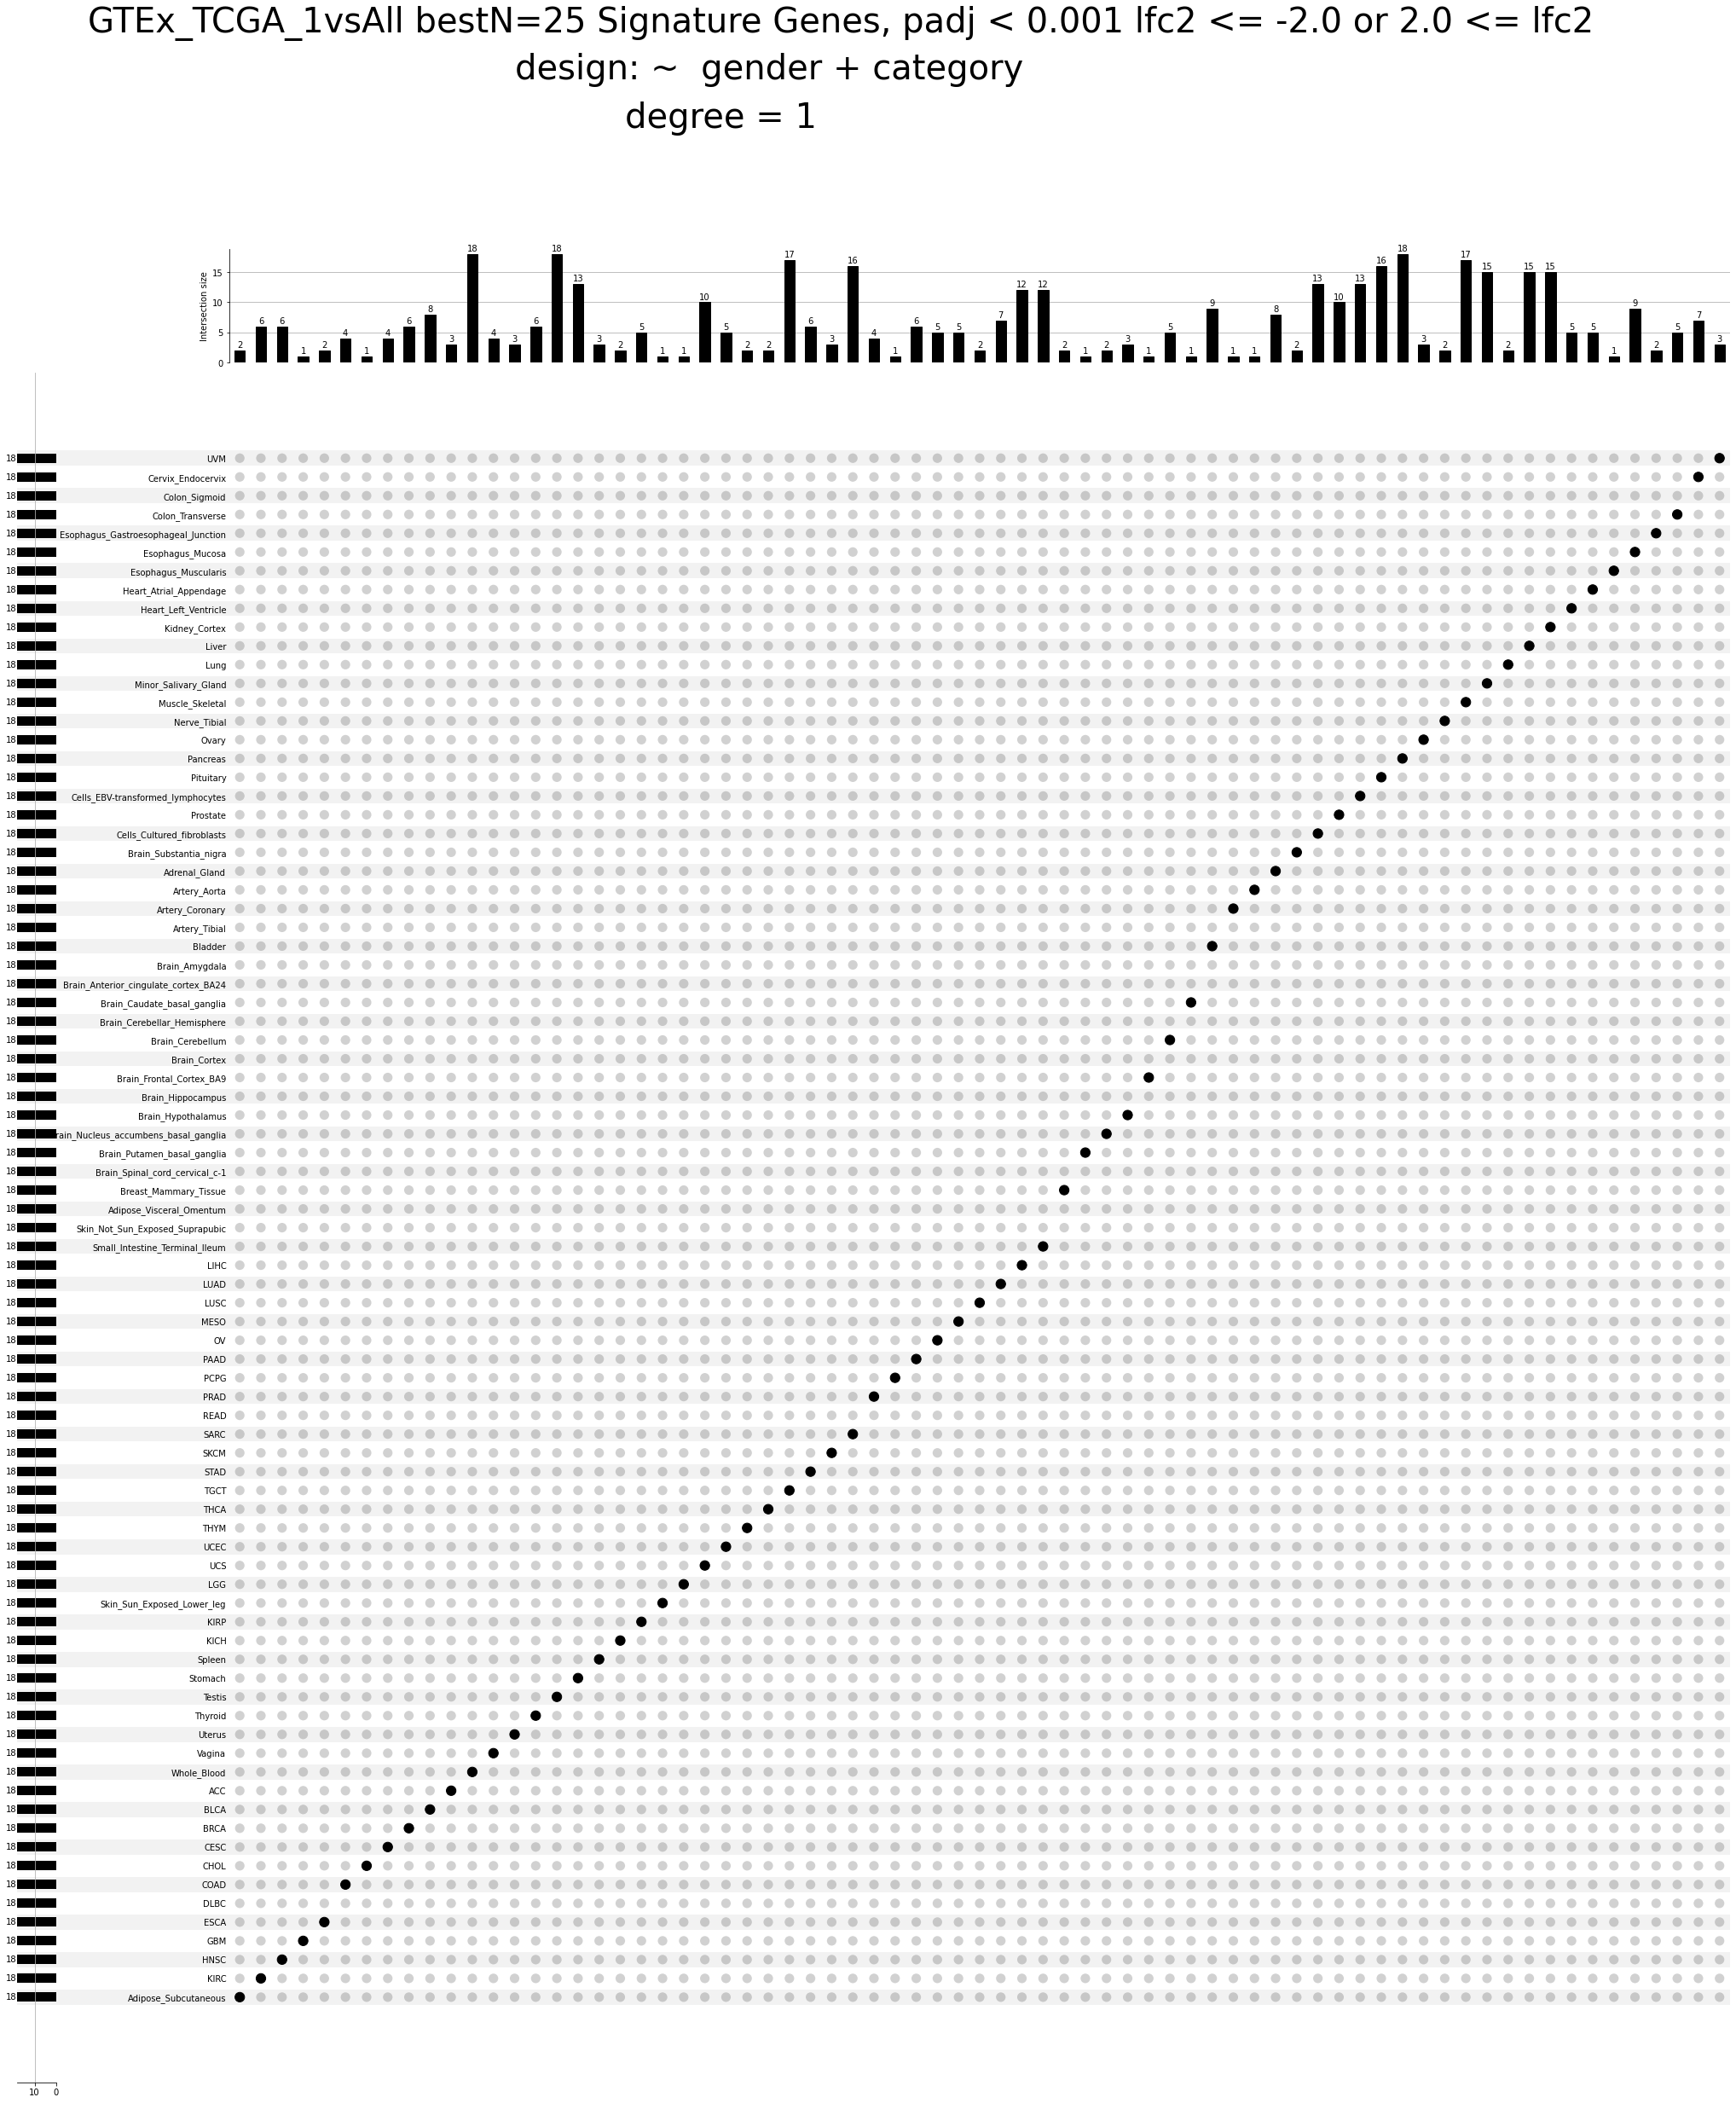

In [36]:
# create a plot sets of genes that are only found in one type
# use extra args to insure saved file name is unique
extraFileNameParts = 'max_degree=1'
fig, pltDict = configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, show_counts=True, max_degree=1)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="degree = 1", fontsize=40)

savePlot(fig, signatureGeneConfig, extraFileNameParts)

### upset plot max_degree = 1 intersection elements

In [37]:
def testFunction(key):
    return key == 1
                
printInserectionElements(setDegreesDict, testFunction)


############### degree: 1 number of intersections:71

setName:Adipose_Subcutaneous
 elements:
{'HRH3', 'CELF5'}

setName:Adrenal_Gland
 elements:
{'CYP11A1', 'TNXA', 'HSD3BP2', 'LINC02732', 'AC004158.1', 'GSTA9P', 'CYP21A2', 'BCAS1'}

setName:Artery_Aorta
 elements:
{'PLPPR1'}

setName:Artery_Coronary
 elements:
{'AC116565.1'}

setName:Bladder
 elements:
{'AC243585.2', 'BZW1P2', 'ANO1-AS1', 'AC243964.4', 'AC012370.2', 'INE2', 'FOXI3', 'ANKRD34C-AS1', 'RSC1A1'}

setName:Brain_Caudate_basal_ganglia
 elements:
{'PKHD1'}

setName:Brain_Cerebellum
 elements:
{'HMGA2', 'LINC01559', 'SMIM41', 'HOXA10', 'ALPK2'}

setName:Brain_Frontal_Cortex_BA9
 elements:
{'IGHV3-30'}

setName:Brain_Hypothalamus
 elements:
{'IGHV3-66', 'CIBAR1P2', 'NPVF'}

setName:Brain_Nucleus_accumbens_basal_ganglia
 elements:
{'AC103718.1', 'ANXA8L1'}

setName:Brain_Putamen_basal_ganglia
 elements:
{'RASSF6'}

setName:Brain_Substantia_nigra
 elements:
{'HOXA11', 'MAB21L4'}

setName:Breast_Mammary_Tissue
 elements:
{'AL157

### upset plot: min_degree = 2 max_degree = 3

rm: cannot remove 'output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png': No such file or directory
saving to: output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=2,max_degree=3.png [Content-Type=image/png]...
/ [1 files][  4.4 MiB/  4.4 MiB]                                                
Operation completed over 1 objects/4.4 MiB.                                      


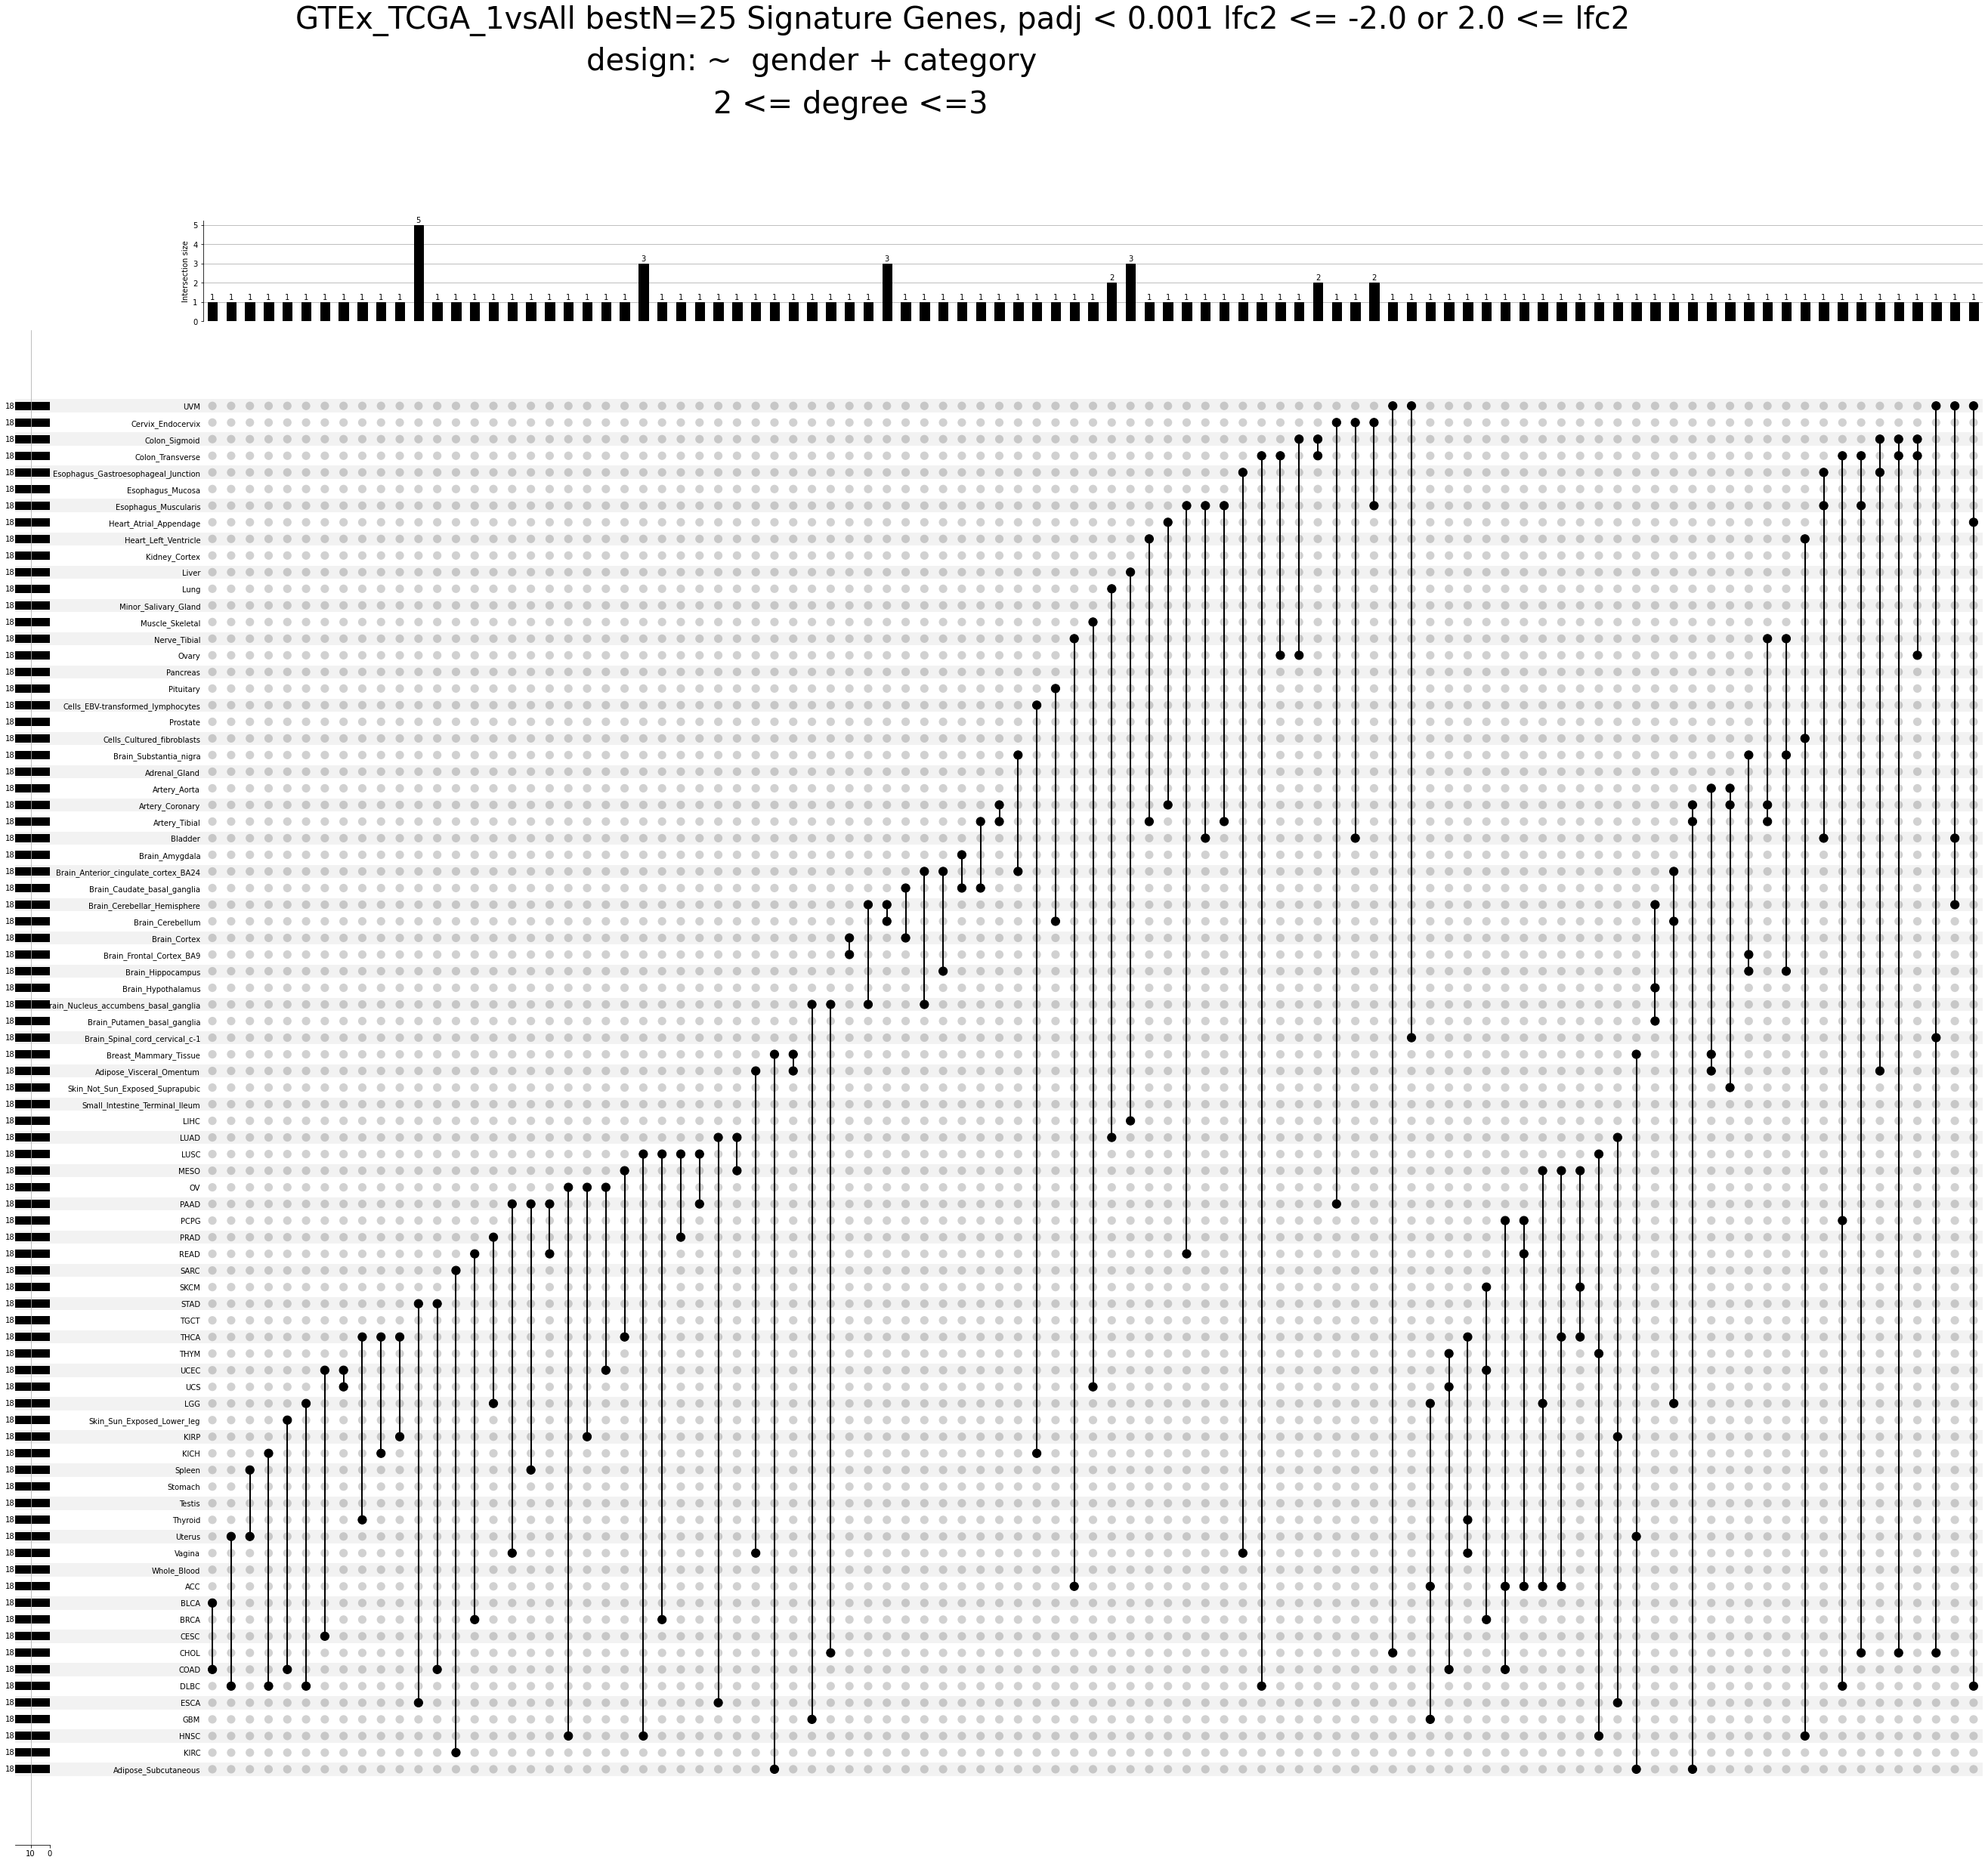

In [38]:
# create a plot of all interesections composed of 4 or more sets
# use extra args to insure saved file name is unique
extraFileNameParts = 'min_degree=2,max_degree=3'
fig, pltDict = configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, show_counts=True, min_degree=2, max_degree=3)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="2 <= degree <=3", fontsize=40)

savePlot(fig, signatureGeneConfig, extraFileNameParts)

### upset plot: min_degree = 2 max_degree = 3 interesections elements

In [39]:
def testFunction(key):
    return key >= 2 and key <= 3
                
printInserectionElements(setDegreesDict, testFunction)


############### degree: 3 number of intersections:30

setName:Adipose_Subcutaneous,Artery_Coronary,Artery_Tibial
 elements:
{'LINC00634', 'LINC00320'}

setName:Adipose_Subcutaneous,Breast_Mammary_Tissue,Uterus
 elements:
{'TAGLN3'}

setName:Adipose_Visceral_Omentum,Artery_Aorta,Breast_Mammary_Tissue
 elements:
{'ST8SIA3', 'SVOP', 'GABRG2', 'KCNQ2', 'SNCB'}

setName:Adipose_Visceral_Omentum,Colon_Sigmoid,Esophagus_Gastroesophageal_Junction
 elements:
{'OLIG2', 'ZIC1'}

setName:Artery_Aorta,Artery_Coronary,Skin_Not_Sun_Exposed_Suprapubic
 elements:
{'CDK5R2', 'ST8SIA3', 'CA10', 'DPYSL5', 'GABRG2'}

setName:Artery_Coronary,Artery_Tibial,Nerve_Tibial
 elements:
{'C1orf61', 'GRIN1', 'LINC00320'}

setName:Bladder,Brain_Cerebellar_Hemisphere,UVM
 elements:
{'CXorf66'}

setName:Bladder,Esophagus_Gastroesophageal_Junction,Esophagus_Muscularis
 elements:
{'AL162511.1'}

setName:Brain_Anterior_cingulate_cortex_BA24,Brain_Cerebellum,LGG
 elements:
{'UGT2B7', 'TNS4'}

setName:Brain_Cerebellar_Hemi

###  upset plot: min_degree = 4 

In [ ]:
# create a plot of all interesections composed of 4 or more sets
# use extra args to insure saved file name is unique
extraFileNameParts = 'min_degree=4'
fig, pltDict = configurablePlot(signatureGeneConfig, geneSetsUpsetPlotData, show_counts=True, min_degree=4)

# add more text to plot
designStr = "design: {}".format(signatureGeneConfig.design)
# hack to find text positions
fig.text(x=0.35, y=0.95, s=designStr, fontsize=40 )
fig.text(x=0.40, y=0.93, s="degree > 4", fontsize=40)


savePlot(fig, signatureGeneConfig, extraFileNameParts)

rm: cannot remove 'output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png': No such file or directory
saving to: output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png
save to :
gs://fc-e15b796f-1abe-4206-ab91-bd58374cc275/data/1vsAll/best/GTEx_TCGA_1vsAll-design:~__gender_+_category-padj:0.001-lfc:2.0-n:25GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png
Copying file://output/GTEx_TCGA_1vsAll-bestN=25-Signature-Genes,-padj-lt-0.001-lfc2-lt=--2.0-or-2.0-lt=-lfc2--min_degree=4.png [Content-Type=image/png]...
/ [1 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 1 objects/5.3 MiB.                                      


###  upset plot: min_degree = 4  interesections elements

In [ ]:
def testFunction(key):
    return key >= 4
                
printInserectionElements(setDegreesDict, testFunction)                